# Data - Train/Val and Test Split by Race

The purpose of this notebook is to train a model with training_horses_4.pkl, which was split from the train data by race_id, not horse_id as the 1-3. dataframes were.  This is a more realistic way to split the train and test data.

Importing packages:

In [1]:
import pandas as pd
from importlib import reload
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

Loading in Functions:

In [2]:
from knn_model_eval import *

In [3]:
from logistic_reg_model_eval import *

In [4]:
from random_forest_evaluator import *

### Change to Markdown after initial cleaning:

## Loading and CLeaning Data:

training_horses_4 = pd.read_pickle('./Data/training_horses_4.pkl')

training_horses_4_copy = training_horses_4.copy()

training_horses_4_copy.info()

### Data Cleaning:

training_horses_4_copy.horse_type.value_counts()

Similar to in initial_model_eda.ipynb, there are some different things going on here.  Will use my same decision:

**Decision: make horses that say color (Brown, Roan, Grey, or None) as "Gelding", since that is 90% of the horses in the set.**

for i, value in enumerate(training_horses_4_copy['horse_type']):
    if training_horses_4_copy.iloc[i, 5] == 'Brown':
        training_horses_4_copy.iloc[i, 5] = "Gelding"
    elif training_horses_4_copy.iloc[i, 5] == 'Roan':
        training_horses_4_copy.iloc[i, 5] = "Gelding"
    elif training_horses_4_copy.iloc[i, 5] == 'Grey':
        training_horses_4_copy.iloc[i, 5] = "Gelding"

#FIlling in any nan gender values with Gelding, for same rationale above.
training_horses_4_copy.horse_type.fillna(value='Gelding', inplace=True)

training_horses_4_copy.horse_type.value_counts()

horse_type is cleaned

### Horse_Country:

training_horses_4_copy.horse_country.value_counts()

Checking out the two that are null:

training_horses_4_copy[training_horses_4_copy.horse_country.isnull()]

Since this is horses 2645, I'll fill check to see if there's info from other races:

training_horses_4_copy[training_horses_4_copy.horse_id == 2645]

There is not.  **DECISION: make country equal to AUS, since that is the most common country**.

training_horses_4_copy.horse_country.fillna(value='AUS', inplace=True)

Country is cleaned.

### Various Feature Engineering Metrics

So these are all horses in their first career race, and based on the math above these account for all of the remaining rate-nulls.  **DECISION: REMOVE THESE ROWS**.  This is a good chunk of data at 3500+ rows, but in my opinion I wouldn't be betting smartly if I bet on a horse I had no previous race data on.  Thus, based on the use case these are ok to exclude from the model.

training_horses_4_cleaned = training_horses_4_copy[training_horses_4_copy['three_race_rolling_average_lengths'].notna()]

training_horses_4_cleaned.place_odds.describe()

training_horses_4_cleaned.info()

training_horses_4_cleaned.sample(10)

## Pickling Data, so i don't have to clean again.

Changing code to markdown after using once:

training_horses_4_cleaned.to_pickle("./Data/training_horses_4_cleaned.pkl")

Reading in the pickled data:

In [5]:
training_horses_4_cleaned = pd.read_pickle('./Data/training_horses_4_cleaned.pkl')

### One Hot Encoding of Gender (horse_type):

In [6]:
ohe = OneHotEncoder(drop='first', sparse=False)

In [7]:
training_model_gender_cat = training_horses_4_cleaned.loc[:, ['horse_type']]

In [8]:
ohe.fit(training_model_gender_cat)

ohe_X = ohe.transform(training_model_gender_cat)

columns = ohe.get_feature_names(['horse_type'])

ohe_X_df = pd.DataFrame(ohe_X, columns=columns, index=training_model_gender_cat.index)

ohe_X_df.sample(20)

,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
34530,0.0,1.0,0.0,0.0,0.0
28162,0.0,1.0,0.0,0.0,0.0
41992,0.0,1.0,0.0,0.0,0.0
27938,0.0,1.0,0.0,0.0,0.0
52805,0.0,1.0,0.0,0.0,0.0
46985,0.0,1.0,0.0,0.0,0.0
25379,0.0,1.0,0.0,0.0,0.0
75450,0.0,1.0,0.0,0.0,0.0
64220,0.0,1.0,0.0,0.0,0.0
52559,0.0,1.0,0.0,0.0,0.0


Concatenating back into the original data frame:

In [9]:
comb_training_horses_4_cleaned = pd.concat([training_horses_4_cleaned, ohe_X_df], axis=1)

In [10]:
comb_training_horses_4_cleaned.head()

,race_id,horse_id,result,lengths_behind,horse_age,horse_type,horse_country,horse_rating,horse_gear,declared_weight,...,diff_from_field_handicap_wgt_avg,field_handicap_wgt_rank,career_races,career_shows,shows_in_last_5_races,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
1,6348,1698,2,0.20,6,Gelding,AUS,92,TT/B,1172.0,...,4.214286,4,36,13.0,2.0,0.0,1.0,0.0,0.0,0.0
2,6348,932,3,0.50,5,Gelding,AUS,88,B,1060.0,...,0.214286,8,19,6.0,1.0,0.0,1.0,0.0,0.0,0.0
3,6348,833,4,0.75,4,Gelding,IRE,89,CP,1154.0,...,1.214286,7,19,9.0,2.0,0.0,1.0,0.0,0.0,0.0
4,6348,3368,5,1.25,3,Gelding,GER,91,TT/B/H,1147.0,...,3.214286,5,4,4.0,4.0,0.0,1.0,0.0,0.0,0.0
5,6348,1238,6,1.25,5,Gelding,AUS,87,TT/V,1191.0,...,-2.785714,10,25,12.0,1.0,0.0,1.0,0.0,0.0,0.0


In [11]:
#Removing original horse_type column:
comb_training_horses_4_cleaned.drop(columns='horse_type', inplace=True)
comb_training_horses_4_cleaned.head()

,race_id,horse_id,result,lengths_behind,horse_age,horse_country,horse_rating,horse_gear,declared_weight,actual_weight,...,diff_from_field_handicap_wgt_avg,field_handicap_wgt_rank,career_races,career_shows,shows_in_last_5_races,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
1,6348,1698,2,0.20,6,AUS,92,TT/B,1172.0,129,...,4.214286,4,36,13.0,2.0,0.0,1.0,0.0,0.0,0.0
2,6348,932,3,0.50,5,AUS,88,B,1060.0,125,...,0.214286,8,19,6.0,1.0,0.0,1.0,0.0,0.0,0.0
3,6348,833,4,0.75,4,IRE,89,CP,1154.0,126,...,1.214286,7,19,9.0,2.0,0.0,1.0,0.0,0.0,0.0
4,6348,3368,5,1.25,3,GER,91,TT/B/H,1147.0,128,...,3.214286,5,4,4.0,4.0,0.0,1.0,0.0,0.0,0.0
5,6348,1238,6,1.25,5,AUS,87,TT/V,1191.0,122,...,-2.785714,10,25,12.0,1.0,0.0,1.0,0.0,0.0,0.0


OHE Complete.

### Feature Selection:

Adding one more feature for now - show rate (i.e. column career_shows / career_races):

In [12]:
comb_training_horses_4_cleaned['career_show_rate'] = comb_training_horses_4_cleaned['career_shows'] / comb_training_horses_4_cleaned['career_races']

In [13]:
comb_training_horses_4_cleaned.sample(5)

,race_id,horse_id,result,lengths_behind,horse_age,horse_country,horse_rating,horse_gear,declared_weight,actual_weight,...,field_handicap_wgt_rank,career_races,career_shows,shows_in_last_5_races,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig,career_show_rate
74409,403,2996,4,1.75,3,AUS,60,--,1074.0,132,...,2,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
77233,177,1824,8,12.75,3,AUS,60,--,1097.0,123,...,2,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
58308,1687,191,6,3.75,3,NZ,60,--,1021.0,119,...,8,5,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.200000
45179,2735,3878,2,4.25,3,NZ,60,--,1153.0,119,...,13,40,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.175000
21361,4645,2444,10,9.00,4,NZ,78,TT/B,1172.0,131,...,2,22,9.0,2.0,0.0,1.0,0.0,0.0,0.0,0.409091


In [14]:
comb_training_horses_4_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59914 entries, 1 to 79203
Data columns (total 45 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   race_id                                       59914 non-null  int64  
 1   horse_id                                      59914 non-null  int64  
 2   result                                        59914 non-null  int64  
 3   lengths_behind                                59914 non-null  float64
 4   horse_age                                     59914 non-null  int64  
 5   horse_country                                 59914 non-null  object 
 6   horse_rating                                  59914 non-null  int64  
 7   horse_gear                                    59914 non-null  object 
 8   declared_weight                               59914 non-null  float64
 9   actual_weight                                 59914 non-null 

In [15]:
columns_1 = ['horse_age', 'distance', 'horses_in_field','declared_weight', 'actual_weight', 'horse_rating', 'draw', 'three_race_rolling_avg_finish', 'three_race_rolling_average_lengths', 'three_race_rolling_average_time', 'three_race_rolling_average_distance_per_time', 'field_rating_rank', 'diff_from_field_rating_avg', 'field_age_rank', 'diff_from_field_age_avg', 'diff_from_field_declared_wgt_avg', 'field_dec_wgt_rank', 'diff_from_field_handicap_wgt_avg', 'field_handicap_wgt_rank', 'career_races', 'career_shows', 'shows_in_last_5_races', 'career_show_rate', 'horse_type_Filly', 'horse_type_Gelding', 'horse_type_Horse', 'horse_type_Mare', 'horse_type_Rig']

In [16]:
for i, feature in enumerate(columns_1, 1):
    print("Feature {}: {}".format(i, feature))

Feature 1: horse_age
Feature 2: distance
Feature 3: horses_in_field
Feature 4: declared_weight
Feature 5: actual_weight
Feature 6: horse_rating
Feature 7: draw
Feature 8: three_race_rolling_avg_finish
Feature 9: three_race_rolling_average_lengths
Feature 10: three_race_rolling_average_time
Feature 11: three_race_rolling_average_distance_per_time
Feature 12: field_rating_rank
Feature 13: diff_from_field_rating_avg
Feature 14: field_age_rank
Feature 15: diff_from_field_age_avg
Feature 16: diff_from_field_declared_wgt_avg
Feature 17: field_dec_wgt_rank
Feature 18: diff_from_field_handicap_wgt_avg
Feature 19: field_handicap_wgt_rank
Feature 20: career_races
Feature 21: career_shows
Feature 22: shows_in_last_5_races
Feature 23: career_show_rate
Feature 24: horse_type_Filly
Feature 25: horse_type_Gelding
Feature 26: horse_type_Horse
Feature 27: horse_type_Mare
Feature 28: horse_type_Rig


## Running Baseline Models:

All models with K-Fold cross validation w/ k=5 folds.

In [17]:
X = comb_training_horses_4_cleaned[columns_1]
y = comb_training_horses_4_cleaned['show']

In [18]:
knn = KNN_accuracy_scorer_f_fold(X, y, n = 41, k=5)

Confusion Matrix for Fold 1
[[8771  239]
 [2708  265]]


Confusion Matrix for Fold 2
[[8770  223]
 [2711  279]]


Confusion Matrix for Fold 3
[[8832  245]
 [2639  267]]


Confusion Matrix for Fold 4
[[8889  225]
 [2618  251]]


Confusion Matrix for Fold 5
[[8826  245]
 [2629  282]]


KNN Classification w/ KFOLD CV Results (k=5):
KNN Accuracy scores:  [0.754068263373112, 0.7551531336059417, 0.7593257114245181, 0.7627472252357507, 0.7601402103154732] 

Simple mean cv accuracy: 0.758 + 0.003 

KNN Precision scores:  [0.5257936507936508, 0.5557768924302788, 0.521484375, 0.5273109243697479, 0.5351043643263758] 

Simple mean cv precision: 0.533 +- 0.012 

KNN Recall scores:  [0.0891355533131517, 0.09331103678929765, 0.09187887130075706, 0.08748692924363889, 0.09687392648574374] 

Simple mean cv recall: 0.092 +- 0.003 

KNN Fbeta (beta=0.5) scores:  [0.2655842854279415, 0.27911164465786314, 0.26947920872022607, 0.26293735596061174, 0.28093245666467426] 

Simple mean cv Fbeta (beta=0.5): 0.272

In [19]:
logreg = log_accuracy_scorer_k_fold(X, y, k=5, threshold=0.5, C=1)

Confusion Matrix for Fold 1
[[8752  258]
 [2652  321]]


Confusion Matrix for Fold 2
[[8743  250]
 [2658  332]]


Confusion Matrix for Fold 3
[[8778  299]
 [2590  316]]


Confusion Matrix for Fold 4
[[8880  234]
 [2538  331]]


Confusion Matrix for Fold 5
[[8800  271]
 [2595  316]]


Logistic Regression Classification w/ KFOLD CV Results (k=5):
Log. Reg Accuracy scores:  [0.7571559709588583, 0.7573228740716015, 0.7589084536426605, 0.7686722857381291, 0.7608078784843932] 

Simple mean cv accuracy: 0.761 + 0.004 

Log. Reg Precision scores:  [0.5544041450777202, 0.570446735395189, 0.5138211382113821, 0.5858407079646017, 0.5383304940374787] 

Simple mean cv precision: 0.553 +- 0.025 

Log. Reg Recall scores:  [0.10797174571140263, 0.11103678929765887, 0.10874053682037164, 0.11537120948065528, 0.10855376159395397] 

Simple mean cv recall: 0.110 +- 0.003 

Log. Reg Fbeta (beta=0.5) scores:  [0.30346001134429956, 0.3121474238435502, 0.2944465150950428, 0.3226749853772665, 0.3004373455029473]

In [20]:
rf_model = random_forest_eval_kfold(X,y, k=5)

Confusion Matrix for Fold 1
[[8680  330]
 [2609  364]]


Confusion Matrix for Fold 2
[[8658  335]
 [2605  385]]


Confusion Matrix for Fold 3
[[8752  325]
 [2530  376]]


Confusion Matrix for Fold 4
[[8792  322]
 [2493  376]]


Confusion Matrix for Fold 5
[[8746  325]
 [2532  379]]


Random Forest Classification w/ KFOLD CV Results (k=5, threshold = 0.5):
Random Forest Accuracy scores:  [0.7560711007260286, 0.7555703913877994, 0.7629975799048653, 0.7659183843778686, 0.7611417125688533] 

Simple mean cv accuracy: 0.760 + 0.004
Random Forest Precision scores:  [0.5244956772334294, 0.5347222222222222, 0.536376604850214, 0.5386819484240688, 0.5383522727272727] 

Simple mean cv precision: 0.535 +- 0.005
Random Forest Recall scores:  [0.12243525058863101, 0.12876254180602006, 0.1293874741913283, 0.131056117113977, 0.13019580900034353] 

Simple mean cv recall: 0.128 +- 0.003
Random Forest Fbeta (beta=0.5) scores:  [0.31657679596451554, 0.32793867120954007, 0.3292469352014011, 0.33209680268503

I am also using XGBoost as a possible comparison here, so reading in those functions and scoring:

In [5]:
from xgboost import XGBClassifier

In [6]:
from xgboost_evaluator import *

In [7]:
xg_model = xgboost_eval_kfold(X,y, k=5, threshold = 0.5)

NameError: name 'X' is not defined

Loadfrom xgboost import plot_importance
import xgboost as xgb

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

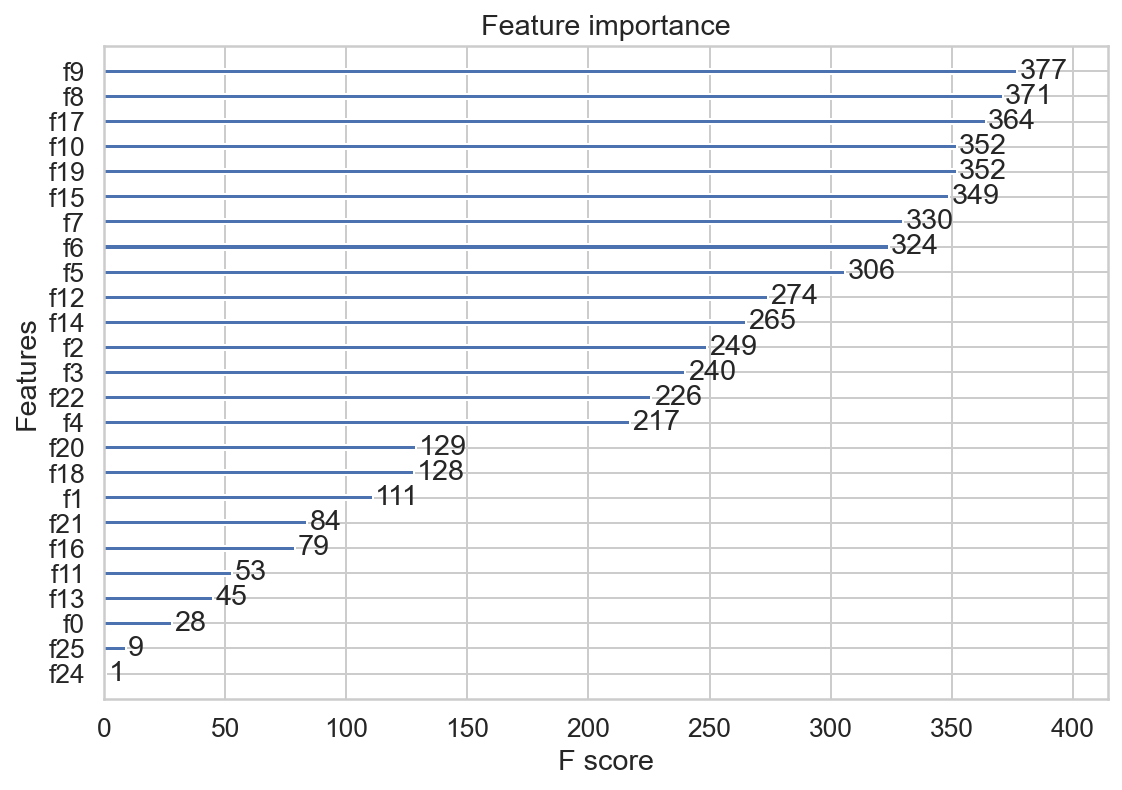

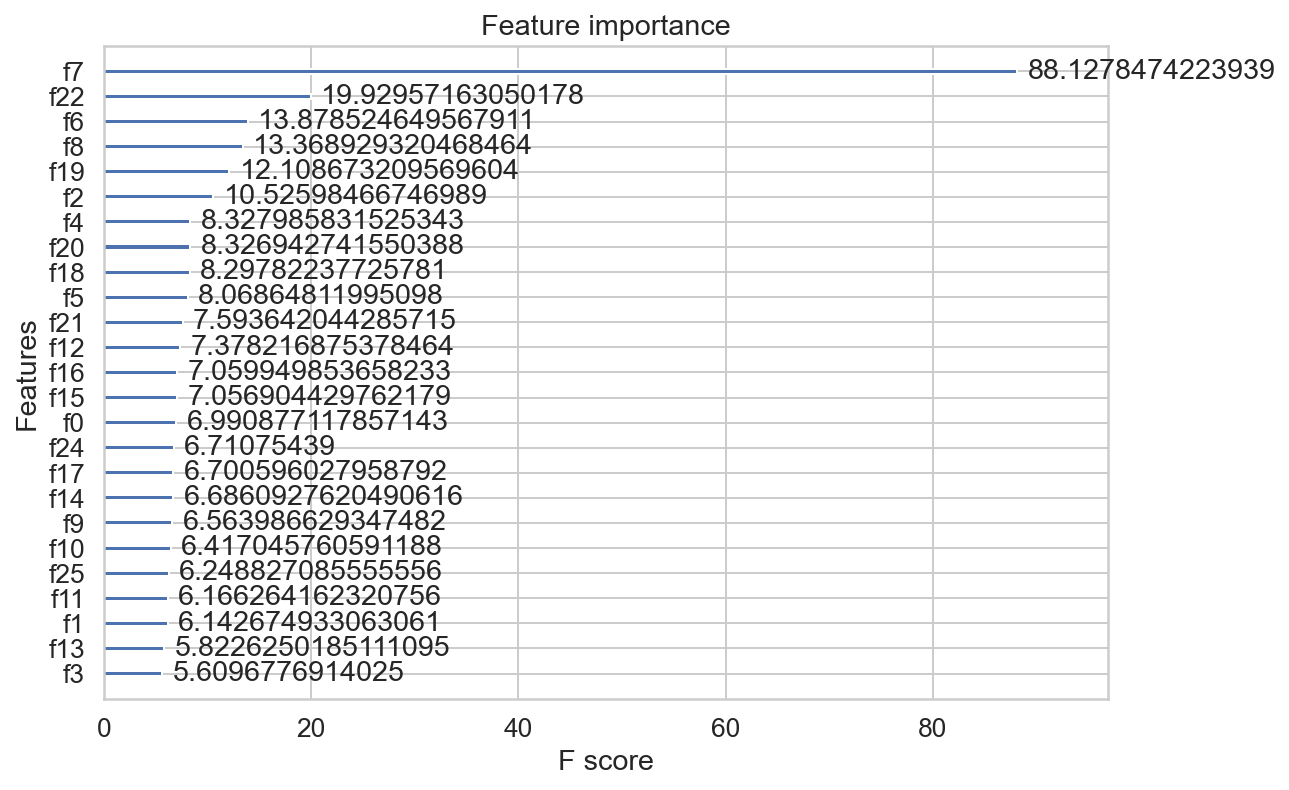

In [25]:
xgb.plot_importance(xg_model)
xgb.plot_importance(xg_model, importance_type='gain')

In [26]:
xg_model.get_booster().feature_names

['f0',
 'f1',
 'f2',
 'f3',
 'f4',
 'f5',
 'f6',
 'f7',
 'f8',
 'f9',
 'f10',
 'f11',
 'f12',
 'f13',
 'f14',
 'f15',
 'f16',
 'f17',
 'f18',
 'f19',
 'f20',
 'f21',
 'f22',
 'f23',
 'f24',
 'f25',
 'f26',
 'f27']

After running these, here are my initial results from KFold cross validation w/ 5 crossfolds:

| Model Type              | Mean Precision Score |Mean FBeta (beta = 0.5 Score)|
| ------------------------| ---------------------|-----------------------------|
| KNN (n=41)              | .533 +- .012         | .272 +- .007                |
| Logistic Regression     | .553 +- .025         | .307 +- .010                |
| Random Forest (untuned) | .531 +- .008         | .326 +- .007                |
| XGBoost (untuned)       | .578 +- .004         | .301 +- .007                |

# Including Place Odds as a feature:

This was not included previously.  My rationale here is that the odds could help with one of my challenge cases, where horses in races with many low rated horses had very low probability of showing.  The odds would be known before the race.  I am going to drop out all horses without odds from the model, since in the gambling use case you can't bet on a horse with no odds.

In [27]:
comb_training_horses_4_cleaned_po = comb_training_horses_4_cleaned[comb_training_horses_4_cleaned['place_odds'].notna()]

In [28]:
comb_training_horses_4_cleaned_po.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57086 entries, 2736 to 79203
Data columns (total 45 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   race_id                                       57086 non-null  int64  
 1   horse_id                                      57086 non-null  int64  
 2   result                                        57086 non-null  int64  
 3   lengths_behind                                57086 non-null  float64
 4   horse_age                                     57086 non-null  int64  
 5   horse_country                                 57086 non-null  object 
 6   horse_rating                                  57086 non-null  int64  
 7   horse_gear                                    57086 non-null  object 
 8   declared_weight                               57086 non-null  float64
 9   actual_weight                                 57086 non-nu

In [29]:
columns_2 = ['horse_age', 'place_odds','distance', 'horses_in_field','declared_weight', 'actual_weight', 'horse_rating', 'draw', 'three_race_rolling_avg_finish', 'three_race_rolling_average_lengths', 'three_race_rolling_average_time', 'three_race_rolling_average_distance_per_time', 'field_rating_rank', 'diff_from_field_rating_avg', 'field_age_rank', 'diff_from_field_age_avg', 'diff_from_field_declared_wgt_avg', 'field_dec_wgt_rank', 'diff_from_field_handicap_wgt_avg', 'field_handicap_wgt_rank', 'career_races', 'career_shows', 'shows_in_last_5_races', 'career_show_rate', 'horse_type_Filly', 'horse_type_Gelding', 'horse_type_Horse', 'horse_type_Mare', 'horse_type_Rig']

In [30]:
for i, feature in enumerate(columns_2, 1):
    print("Feature {}: {}".format(i, feature))

Feature 1: horse_age
Feature 2: place_odds
Feature 3: distance
Feature 4: horses_in_field
Feature 5: declared_weight
Feature 6: actual_weight
Feature 7: horse_rating
Feature 8: draw
Feature 9: three_race_rolling_avg_finish
Feature 10: three_race_rolling_average_lengths
Feature 11: three_race_rolling_average_time
Feature 12: three_race_rolling_average_distance_per_time
Feature 13: field_rating_rank
Feature 14: diff_from_field_rating_avg
Feature 15: field_age_rank
Feature 16: diff_from_field_age_avg
Feature 17: diff_from_field_declared_wgt_avg
Feature 18: field_dec_wgt_rank
Feature 19: diff_from_field_handicap_wgt_avg
Feature 20: field_handicap_wgt_rank
Feature 21: career_races
Feature 22: career_shows
Feature 23: shows_in_last_5_races
Feature 24: career_show_rate
Feature 25: horse_type_Filly
Feature 26: horse_type_Gelding
Feature 27: horse_type_Horse
Feature 28: horse_type_Mare
Feature 29: horse_type_Rig


## Running Baseline Models:

All models with K-Fold cross validation w/ k=5 folds.

In [31]:
X = comb_training_horses_4_cleaned_po[columns_2]
y = comb_training_horses_4_cleaned_po['show']

In [32]:
knn = KNN_accuracy_scorer_f_fold(X, y, n = 41, k=5)

Confusion Matrix for Fold 1
[[8406  233]
 [2484  295]]


Confusion Matrix for Fold 2
[[8419  234]
 [2507  257]]


Confusion Matrix for Fold 3
[[8400  250]
 [2495  272]]


Confusion Matrix for Fold 4
[[8393  236]
 [2512  276]]


Confusion Matrix for Fold 5
[[8326  238]
 [2554  299]]


KNN Classification w/ KFOLD CV Results (k=5):
KNN Accuracy scores:  [0.7620423892100193, 0.7599194184111413, 0.759569063676973, 0.7593062976263467, 0.7554523955504949] 

Simple mean cv accuracy: 0.759 + 0.002 

KNN Precision scores:  [0.5587121212121212, 0.5234215885947047, 0.5210727969348659, 0.5390625, 0.5567970204841713] 

Simple mean cv precision: 0.540 +- 0.016 

KNN Recall scores:  [0.10615329255127744, 0.09298118668596238, 0.0983014094687387, 0.09899569583931134, 0.10480196284612689] 

Simple mean cv recall: 0.100 +- 0.005 

KNN Fbeta (beta=0.5) scores:  [0.30157432017992225, 0.2717851099830795, 0.28012358393408854, 0.2853598014888338, 0.29894021195760845] 

Simple mean cv Fbeta (beta=0.5): 0.288 +-

In [33]:
logreg = log_accuracy_scorer_k_fold(X, y, k=5, threshold=0.5, C=1)

Confusion Matrix for Fold 1
[[8484  155]
 [2459  320]]


Confusion Matrix for Fold 2
[[8469  184]
 [2484  280]]


Confusion Matrix for Fold 3
[[8450  200]
 [2461  306]]


Confusion Matrix for Fold 4
[[8475  154]
 [2517  271]]


Confusion Matrix for Fold 5
[[8382  182]
 [2538  315]]


Logistic Regression Classification w/ KFOLD CV Results (k=5):
Log. Reg Accuracy scores:  [0.7710632334909792, 0.7663133923097136, 0.7669265130945082, 0.7660506262590874, 0.7617587807655251] 

Simple mean cv accuracy: 0.766 + 0.003 

Log. Reg Precision scores:  [0.6736842105263158, 0.603448275862069, 0.6047430830039525, 0.6376470588235295, 0.6338028169014085] 

Simple mean cv precision: 0.631 +- 0.026 

Log. Reg Recall scores:  [0.11514933429291112, 0.10130246020260492, 0.11058908565233104, 0.09720229555236728, 0.11041009463722397] 

Simple mean cv recall: 0.107 +- 0.007 

Log. Reg Fbeta (beta=0.5) scores:  [0.3419534088480444, 0.303030303030303, 0.319348778960551, 0.3019162210338681, 0.32534600289196447] 


In [34]:
rf_model = random_forest_eval_kfold(X,y, k=5)

Confusion Matrix for Fold 1
[[8158  481]
 [2070  709]]


Confusion Matrix for Fold 2
[[8153  500]
 [2103  661]]


Confusion Matrix for Fold 3
[[8143  507]
 [2057  710]]


Confusion Matrix for Fold 4
[[8166  463]
 [2125  663]]


Confusion Matrix for Fold 5
[[8040  524]
 [2127  726]]


Random Forest Classification w/ KFOLD CV Results (k=5, threshold = 0.5):
Random Forest Accuracy scores:  [0.7773690663864075, 0.7717438906893229, 0.773846019094333, 0.7740211964614172, 0.7672768678286765] 

Simple mean cv accuracy: 0.773 + 0.003
Random Forest Precision scores:  [0.5957983193277311, 0.5693367786391043, 0.5834018077239113, 0.588809946714032, 0.5808] 

Simple mean cv precision: 0.584 +- 0.009
Random Forest Recall scores:  [0.2551277437927312, 0.23914616497829233, 0.25659559089266354, 0.23780487804878048, 0.2544689800210305] 

Simple mean cv recall: 0.249 +- 0.008
Random Forest Fbeta (beta=0.5) scores:  [0.4702215147897599, 0.44613930885529157, 0.46496398166339226, 0.45460778935820073, 0.46224

In [35]:
xg_model = xgboost_eval_kfold(X,y, k=5, threshold = 0.5)

[09:21:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 1
[[8261  378]
 [2098  681]]


[09:21:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 2
[[8141  512]
 [2100  664]]


[09:21:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_met

Updating the table with these results:

| Model Type              | Features   | Mean Precision Score |Mean FBeta (beta = 0.5 Score)|
| ------------------------|------------| ---------------------|-----------------------------|
| KNN (n=41)              | columns_1  | .533 +- .012         | .272 +- .007                |
| Logistic Regression     | columns_1  | .553 +- .025         | .307 +- .010                |
| Random Forest (untuned) | columns_1  | .531 +- .008         | .326 +- .007                |
| XGBoost (untuned)       | columns_1  | .578 +- .004         | .301 +- .007                |
| KNN (n=41)              | columns_2* | .540 +- .016         | .288 +- .011                |
| Logistic Regression     | columns_2* | .631 +- .026         | .318 +- .015                |
| Random Forest (untuned) | columns_2* | .579 +- .010         | .456 +- .008                |
| XGBoost (untuned)       | columns_2* | .604 +- .025         | .464 +- .013                |

*column_2 is the same as column_1, just with place_odds included in the features

# Changing Rolling Averages from 3 Races to 2:

What if there is more variability in race to race results, so the previous two races have more of an effect than three?

### Changnig to Markdown after initial pickle/cleaning:

training_horses_5 = pd.read_pickle('./Data/training_horses_5.pkl')

training_horses_5_copy = training_horses_5.copy()

training_horses_5_copy.info()

### Data Cleaning:

for i, value in enumerate(training_horses_5_copy['horse_type']):
    if training_horses_5_copy.iloc[i, 5] == 'Brown':
        training_horses_5_copy.iloc[i, 5] = "Gelding"
    elif training_horses_5_copy.iloc[i, 5] == 'Roan':
        training_horses_5_copy.iloc[i, 5] = "Gelding"
    elif training_horses_5_copy.iloc[i, 5] == 'Grey':
        training_horses_5_copy.iloc[i, 5] = "Gelding"

#FIlling in any nan gender values with Gelding, for same rationale above.
training_horses_5_copy.horse_type.fillna(value='Gelding', inplace=True)

training_horses_5_copy.horse_type.value_counts()

training_horses_5_copy.horse_country.fillna(value='AUS', inplace=True)

### Various Feature Engineering Metrics

training_horses_5_cleaned = training_horses_5_copy[training_horses_5_copy['two_race_rolling_average_lengths'].notna()]

## Pickling Data, so i don't have to clean again.

Changing code to markdown after using once:

training_horses_5_cleaned.to_pickle("./Data/training_horses_5_cleaned.pkl")

Reading in the pickled data:

In [36]:
training_horses_5_cleaned = pd.read_pickle('./Data/training_horses_5_cleaned.pkl')

### One Hot Encoding of Gender (horse_type):

In [37]:
ohe = OneHotEncoder(drop='first', sparse=False)

In [38]:
training_model_gender_cat = training_horses_5_cleaned.loc[:, ['horse_type']]

In [39]:
ohe.fit(training_model_gender_cat)

ohe_X = ohe.transform(training_model_gender_cat)

columns = ohe.get_feature_names(['horse_type'])

ohe_X_df = pd.DataFrame(ohe_X, columns=columns, index=training_model_gender_cat.index)

ohe_X_df.sample(20)

,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
20561,0.0,1.0,0.0,0.0,0.0
36162,0.0,1.0,0.0,0.0,0.0
51550,0.0,1.0,0.0,0.0,0.0
41157,0.0,1.0,0.0,0.0,0.0
58776,0.0,1.0,0.0,0.0,0.0
13696,0.0,1.0,0.0,0.0,0.0
47097,0.0,1.0,0.0,0.0,0.0
52558,0.0,1.0,0.0,0.0,0.0
59078,0.0,1.0,0.0,0.0,0.0
43740,0.0,1.0,0.0,0.0,0.0


Concatenating back into the original data frame:

In [40]:
comb_training_horses_5_cleaned = pd.concat([training_horses_5_cleaned, ohe_X_df], axis=1)

In [41]:
comb_training_horses_5_cleaned.head()

,race_id,horse_id,result,lengths_behind,horse_age,horse_type,horse_country,horse_rating,horse_gear,declared_weight,...,diff_from_field_handicap_wgt_avg,field_handicap_wgt_rank,career_races,career_shows,shows_in_last_5_races,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
1,6348,1698,2,0.20,6,Gelding,AUS,92,TT/B,1172.0,...,4.214286,4,36,13.0,2.0,0.0,1.0,0.0,0.0,0.0
2,6348,932,3,0.50,5,Gelding,AUS,88,B,1060.0,...,0.214286,8,19,6.0,1.0,0.0,1.0,0.0,0.0,0.0
3,6348,833,4,0.75,4,Gelding,IRE,89,CP,1154.0,...,1.214286,7,19,9.0,2.0,0.0,1.0,0.0,0.0,0.0
4,6348,3368,5,1.25,3,Gelding,GER,91,TT/B/H,1147.0,...,3.214286,5,4,4.0,4.0,0.0,1.0,0.0,0.0,0.0
5,6348,1238,6,1.25,5,Gelding,AUS,87,TT/V,1191.0,...,-2.785714,10,25,12.0,1.0,0.0,1.0,0.0,0.0,0.0


In [42]:
#Removing original horse_type column:
comb_training_horses_5_cleaned.drop(columns='horse_type', inplace=True)
comb_training_horses_5_cleaned.head()

,race_id,horse_id,result,lengths_behind,horse_age,horse_country,horse_rating,horse_gear,declared_weight,actual_weight,...,diff_from_field_handicap_wgt_avg,field_handicap_wgt_rank,career_races,career_shows,shows_in_last_5_races,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
1,6348,1698,2,0.20,6,AUS,92,TT/B,1172.0,129,...,4.214286,4,36,13.0,2.0,0.0,1.0,0.0,0.0,0.0
2,6348,932,3,0.50,5,AUS,88,B,1060.0,125,...,0.214286,8,19,6.0,1.0,0.0,1.0,0.0,0.0,0.0
3,6348,833,4,0.75,4,IRE,89,CP,1154.0,126,...,1.214286,7,19,9.0,2.0,0.0,1.0,0.0,0.0,0.0
4,6348,3368,5,1.25,3,GER,91,TT/B/H,1147.0,128,...,3.214286,5,4,4.0,4.0,0.0,1.0,0.0,0.0,0.0
5,6348,1238,6,1.25,5,AUS,87,TT/V,1191.0,122,...,-2.785714,10,25,12.0,1.0,0.0,1.0,0.0,0.0,0.0


OHE Complete.

### Feature Selection:

Adding one more feature for now - show rate (i.e. column career_shows / career_races):

In [43]:
comb_training_horses_5_cleaned['career_show_rate'] = comb_training_horses_5_cleaned['career_shows'] / comb_training_horses_5_cleaned['career_races']

In [44]:
comb_training_horses_5_cleaned_po = comb_training_horses_5_cleaned[comb_training_horses_5_cleaned['place_odds'].notna()]

In [45]:
comb_training_horses_5_cleaned_po .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57086 entries, 2736 to 79203
Data columns (total 45 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   race_id                                     57086 non-null  int64  
 1   horse_id                                    57086 non-null  int64  
 2   result                                      57086 non-null  int64  
 3   lengths_behind                              57086 non-null  float64
 4   horse_age                                   57086 non-null  int64  
 5   horse_country                               57086 non-null  object 
 6   horse_rating                                57086 non-null  int64  
 7   horse_gear                                  57086 non-null  object 
 8   declared_weight                             57086 non-null  float64
 9   actual_weight                               57086 non-null  int64  
 10  draw   

In [46]:
columns_3 = ['horse_age', 'place_odds','distance', 'horses_in_field','declared_weight', 'actual_weight', 'horse_rating', 'draw', 'two_race_rolling_avg_finish', 'two_race_rolling_average_lengths', 'two_race_rolling_average_time', 'two_race_rolling_average_distance_per_time', 'field_rating_rank', 'diff_from_field_rating_avg', 'field_age_rank', 'diff_from_field_age_avg', 'diff_from_field_declared_wgt_avg', 'field_dec_wgt_rank', 'diff_from_field_handicap_wgt_avg', 'field_handicap_wgt_rank', 'career_races', 'career_shows', 'shows_in_last_5_races', 'career_show_rate', 'horse_type_Filly', 'horse_type_Gelding', 'horse_type_Horse', 'horse_type_Mare', 'horse_type_Rig']

In [47]:
for i, feature in enumerate(columns_3, 1):
    print("Feature {}: {}".format(i, feature))

Feature 1: horse_age
Feature 2: place_odds
Feature 3: distance
Feature 4: horses_in_field
Feature 5: declared_weight
Feature 6: actual_weight
Feature 7: horse_rating
Feature 8: draw
Feature 9: two_race_rolling_avg_finish
Feature 10: two_race_rolling_average_lengths
Feature 11: two_race_rolling_average_time
Feature 12: two_race_rolling_average_distance_per_time
Feature 13: field_rating_rank
Feature 14: diff_from_field_rating_avg
Feature 15: field_age_rank
Feature 16: diff_from_field_age_avg
Feature 17: diff_from_field_declared_wgt_avg
Feature 18: field_dec_wgt_rank
Feature 19: diff_from_field_handicap_wgt_avg
Feature 20: field_handicap_wgt_rank
Feature 21: career_races
Feature 22: career_shows
Feature 23: shows_in_last_5_races
Feature 24: career_show_rate
Feature 25: horse_type_Filly
Feature 26: horse_type_Gelding
Feature 27: horse_type_Horse
Feature 28: horse_type_Mare
Feature 29: horse_type_Rig


## Running Baseline Models:

All models with K-Fold cross validation w/ k=5 folds.

In [48]:
X = comb_training_horses_5_cleaned_po[columns_3]
y = comb_training_horses_5_cleaned_po['show']

In [49]:
knn = KNN_accuracy_scorer_f_fold(X, y, n = 41, k=5)

Confusion Matrix for Fold 1
[[8410  229]
 [2475  304]]


Confusion Matrix for Fold 2
[[8426  227]
 [2508  256]]


Confusion Matrix for Fold 3
[[8395  255]
 [2464  303]]


Confusion Matrix for Fold 4
[[8394  235]
 [2493  295]]


Confusion Matrix for Fold 5
[[8311  253]
 [2536  317]]


KNN Classification w/ KFOLD CV Results (k=5):
KNN Accuracy scores:  [0.7631809423716939, 0.7604449505123938, 0.7618463694490671, 0.7610580712971884, 0.7557151616011212] 

Simple mean cv accuracy: 0.760 + 0.003 

KNN Precision scores:  [0.5703564727954972, 0.5300207039337475, 0.543010752688172, 0.5566037735849056, 0.5561403508771929] 

Simple mean cv precision: 0.551 +- 0.014 

KNN Recall scores:  [0.10939186757826556, 0.09261939218523878, 0.10950487893024936, 0.1058106169296987, 0.1111111111111111] 

Simple mean cv recall: 0.106 +- 0.007 

KNN Fbeta (beta=0.5) scores:  [0.30950926491549585, 0.27257240204429295, 0.30306061212242447, 0.3005297473512632, 0.3087862848236898] 

Simple mean cv Fbeta (beta=0.5): 

In [50]:
logreg = log_accuracy_scorer_k_fold(X, y, k=5, threshold=0.5, C=1)

Confusion Matrix for Fold 1
[[8479  160]
 [2461  318]]


Confusion Matrix for Fold 2
[[8467  186]
 [2485  279]]


Confusion Matrix for Fold 3
[[8446  204]
 [2461  306]]


Confusion Matrix for Fold 4
[[8469  160]
 [2515  273]]


Confusion Matrix for Fold 5
[[8384  180]
 [2539  314]]


Logistic Regression Classification w/ KFOLD CV Results (k=5):
Log. Reg Accuracy scores:  [0.7704501664039236, 0.7660506262590874, 0.7665761583603399, 0.7657002715249189, 0.7618463694490671] 

Simple mean cv accuracy: 0.766 + 0.003 

Log. Reg Precision scores:  [0.6652719665271967, 0.6, 0.6, 0.6304849884526559, 0.6356275303643725] 

Simple mean cv precision: 0.626 +- 0.025 

Log. Reg Recall scores:  [0.11442965095358043, 0.10094066570188133, 0.11058908565233104, 0.0979196556671449, 0.11005958640028041] 

Simple mean cv recall: 0.107 +- 0.006 

Log. Reg Fbeta (beta=0.5) scores:  [0.33894691963334045, 0.30168685121107264, 0.31828583315997505, 0.3019911504424779, 0.3251190722716918] 

Simple mean cv Fbeta (bet

In [51]:
rf_model = random_forest_eval_kfold(X,y, k=5)

Confusion Matrix for Fold 1
[[8170  469]
 [2076  703]]


Confusion Matrix for Fold 2
[[8142  511]
 [2106  658]]


Confusion Matrix for Fold 3
[[8147  503]
 [2084  683]]


Confusion Matrix for Fold 4
[[8162  467]
 [2115  673]]


Confusion Matrix for Fold 5
[[8035  529]
 [2133  720]]


Random Forest Classification w/ KFOLD CV Results (k=5, threshold = 0.5):
Random Forest Accuracy scores:  [0.7770187423366615, 0.7713059472716125, 0.774897083296838, 0.7749846719803801, 0.7673644565122186] 

Simple mean cv accuracy: 0.773 + 0.003
Random Forest Precision scores:  [0.5998293515358362, 0.562874251497006, 0.575885328836425, 0.5903508771929824, 0.5764611689351481] 

Simple mean cv precision: 0.581 +- 0.013
Random Forest Recall scores:  [0.25296869377473913, 0.23806078147612156, 0.24683773039392845, 0.24139167862266858, 0.25236593059936907] 

Simple mean cv recall: 0.246 +- 0.006
Random Forest Fbeta (beta=0.5) scores:  [0.47073791348600513, 0.4422043010752688, 0.4546664891492478, 0.45794774088187

In [52]:
xg_model = xgboost_eval_kfold(X,y, k=5, threshold = 0.5)

[09:25:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 1
[[8260  379]
 [2099  680]]


[09:25:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 2
[[8173  480]
 [2111  653]]


[09:25:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_met

Updating the table with these results:

| Model Type              | Features    | Mean Precision Score |Mean FBeta (beta = 0.5 Score)|
| ------------------------|-------------| ---------------------|-----------------------------|
| KNN (n=41)              | columns_1   | .533 +- .012         | .272 +- .007                |
| Logistic Regression     | columns_1   | .553 +- .025         | .307 +- .010                |
| Random Forest (untuned) | columns_1   | .531 +- .008         | .326 +- .007                |
| XGBoost (untuned)       | columns_1   | .578 +- .004         | .301 +- .007                |
| KNN (n=41)              | columns_2*  | .540 +- .016         | .288 +- .011                |
| Logistic Regression     | columns_2*  | .631 +- .026         | .318 +- .015                |
| Random Forest (untuned) | columns_2*  | .579 +- .010         | .456 +- .008                |
| XGBoost (untuned)       | columns_2*  | .604 +- .025         | .464 +- .013                |
| KNN (n=41)              | columns_3** | .551 +- .014         | .299 +- .014                |
| Logistic Regression     | columns_3** | .626 +- .025         | .317 +- .014                |
| Random Forest (untuned) | columns_3** | .575 +- .014         | .452 +- .012                |
| XGBoost (untuned)       | columns_3** | .606 +- .021         | .463 +- .012                |

* column_2 is the same as column_1, just with place_odds included in the features
** columns_3 is the same as columns_2, but with three race rolling averages changed to two

Like before, Logistic Regression is leading the way in precision, and XGBoost is leading the way in FBeta.  
Not much difference in performance from the columns_2 set of data.  There doesn't appear to be much difference in changing the rolling average from 3 to 2 races.  What about 5?

## Changing Rolling Average to 5 races:

training_horses_6 = pd.read_pickle('./Data/training_horses_6.pkl')

training_horses_6_copy = training_horses_6.copy()

training_horses_6_copy.info()

### Data Cleaning:

for i, value in enumerate(training_horses_6_copy['horse_type']):
    if training_horses_6_copy.iloc[i, 5] == 'Brown':
        training_horses_6_copy.iloc[i, 5] = "Gelding"
    elif training_horses_6_copy.iloc[i, 5] == 'Roan':
        training_horses_6_copy.iloc[i, 5] = "Gelding"
    elif training_horses_6_copy.iloc[i, 5] == 'Grey':
        training_horses_6_copy.iloc[i, 5] = "Gelding"

#FIlling in any nan gender values with Gelding, for same rationale above.
training_horses_6_copy.horse_type.fillna(value='Gelding', inplace=True)

training_horses_6_copy.horse_type.value_counts()

training_horses_6_copy.horse_country.fillna(value='AUS', inplace=True)

### Various Feature Engineering Metrics

training_horses_6_cleaned = training_horses_6_copy[training_horses_6_copy['five_race_rolling_average_lengths'].notna()]

## Pickling Data, so i don't have to clean again.

Changing code to markdown after using once:

training_horses_6_cleaned.to_pickle("./Data/training_horses_6_cleaned.pkl")

Reading in the pickled data:

In [53]:
training_horses_6_cleaned = pd.read_pickle('./Data/training_horses_6_cleaned.pkl')

### One Hot Encoding of Gender (horse_type):

In [54]:
ohe = OneHotEncoder(drop='first', sparse=False)

In [55]:
training_model_gender_cat = training_horses_6_cleaned.loc[:, ['horse_type']]

In [56]:
ohe.fit(training_model_gender_cat)

ohe_X = ohe.transform(training_model_gender_cat)

columns = ohe.get_feature_names(['horse_type'])

ohe_X_df = pd.DataFrame(ohe_X, columns=columns, index=training_model_gender_cat.index)

ohe_X_df.sample(20)

,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
62662,0.0,1.0,0.0,0.0,0.0
69377,0.0,1.0,0.0,0.0,0.0
41987,0.0,1.0,0.0,0.0,0.0
27867,0.0,1.0,0.0,0.0,0.0
45587,0.0,1.0,0.0,0.0,0.0
63151,0.0,1.0,0.0,0.0,0.0
40702,0.0,1.0,0.0,0.0,0.0
74564,0.0,1.0,0.0,0.0,0.0
25233,0.0,1.0,0.0,0.0,0.0
70834,0.0,1.0,0.0,0.0,0.0


Concatenating back into the original data frame:

In [57]:
comb_training_horses_6_cleaned = pd.concat([training_horses_6_cleaned, ohe_X_df], axis=1)

In [58]:
comb_training_horses_6_cleaned.head()

,race_id,horse_id,result,lengths_behind,horse_age,horse_type,horse_country,horse_rating,horse_gear,declared_weight,...,diff_from_field_handicap_wgt_avg,field_handicap_wgt_rank,career_races,career_shows,shows_in_last_5_races,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
1,6348,1698,2,0.20,6,Gelding,AUS,92,TT/B,1172.0,...,4.214286,4,36,13.0,2.0,0.0,1.0,0.0,0.0,0.0
2,6348,932,3,0.50,5,Gelding,AUS,88,B,1060.0,...,0.214286,8,19,6.0,1.0,0.0,1.0,0.0,0.0,0.0
3,6348,833,4,0.75,4,Gelding,IRE,89,CP,1154.0,...,1.214286,7,19,9.0,2.0,0.0,1.0,0.0,0.0,0.0
4,6348,3368,5,1.25,3,Gelding,GER,91,TT/B/H,1147.0,...,3.214286,5,4,4.0,4.0,0.0,1.0,0.0,0.0,0.0
5,6348,1238,6,1.25,5,Gelding,AUS,87,TT/V,1191.0,...,-2.785714,10,25,12.0,1.0,0.0,1.0,0.0,0.0,0.0


In [59]:
#Removing original horse_type column:
comb_training_horses_6_cleaned.drop(columns='horse_type', inplace=True)
comb_training_horses_6_cleaned.head()

,race_id,horse_id,result,lengths_behind,horse_age,horse_country,horse_rating,horse_gear,declared_weight,actual_weight,...,diff_from_field_handicap_wgt_avg,field_handicap_wgt_rank,career_races,career_shows,shows_in_last_5_races,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
1,6348,1698,2,0.20,6,AUS,92,TT/B,1172.0,129,...,4.214286,4,36,13.0,2.0,0.0,1.0,0.0,0.0,0.0
2,6348,932,3,0.50,5,AUS,88,B,1060.0,125,...,0.214286,8,19,6.0,1.0,0.0,1.0,0.0,0.0,0.0
3,6348,833,4,0.75,4,IRE,89,CP,1154.0,126,...,1.214286,7,19,9.0,2.0,0.0,1.0,0.0,0.0,0.0
4,6348,3368,5,1.25,3,GER,91,TT/B/H,1147.0,128,...,3.214286,5,4,4.0,4.0,0.0,1.0,0.0,0.0,0.0
5,6348,1238,6,1.25,5,AUS,87,TT/V,1191.0,122,...,-2.785714,10,25,12.0,1.0,0.0,1.0,0.0,0.0,0.0


OHE Complete.

### Feature Selection:

Adding one more feature for now - show rate (i.e. column career_shows / career_races):

In [60]:
comb_training_horses_6_cleaned['career_show_rate'] = comb_training_horses_6_cleaned['career_shows'] / comb_training_horses_6_cleaned['career_races']

In [61]:
comb_training_horses_6_cleaned_po = comb_training_horses_6_cleaned[comb_training_horses_6_cleaned['place_odds'].notna()]

In [62]:
comb_training_horses_6_cleaned_po .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57086 entries, 2736 to 79203
Data columns (total 45 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   race_id                                      57086 non-null  int64  
 1   horse_id                                     57086 non-null  int64  
 2   result                                       57086 non-null  int64  
 3   lengths_behind                               57086 non-null  float64
 4   horse_age                                    57086 non-null  int64  
 5   horse_country                                57086 non-null  object 
 6   horse_rating                                 57086 non-null  int64  
 7   horse_gear                                   57086 non-null  object 
 8   declared_weight                              57086 non-null  float64
 9   actual_weight                                57086 non-null  int64  


In [63]:
columns_4 = ['horse_age', 'place_odds','distance', 'horses_in_field','declared_weight', 'actual_weight', 'horse_rating', 'draw', 'five_race_rolling_avg_finish', 'five_race_rolling_average_lengths', 'five_race_rolling_average_time', 'five_race_rolling_average_distance_per_time', 'field_rating_rank', 'diff_from_field_rating_avg', 'field_age_rank', 'diff_from_field_age_avg', 'diff_from_field_declared_wgt_avg', 'field_dec_wgt_rank', 'diff_from_field_handicap_wgt_avg', 'field_handicap_wgt_rank', 'career_races', 'career_shows', 'shows_in_last_5_races', 'career_show_rate', 'horse_type_Filly', 'horse_type_Gelding', 'horse_type_Horse', 'horse_type_Mare', 'horse_type_Rig']

In [64]:
for i, feature in enumerate(columns_4, 1):
    print("Feature {}: {}".format(i, feature))

Feature 1: horse_age
Feature 2: place_odds
Feature 3: distance
Feature 4: horses_in_field
Feature 5: declared_weight
Feature 6: actual_weight
Feature 7: horse_rating
Feature 8: draw
Feature 9: five_race_rolling_avg_finish
Feature 10: five_race_rolling_average_lengths
Feature 11: five_race_rolling_average_time
Feature 12: five_race_rolling_average_distance_per_time
Feature 13: field_rating_rank
Feature 14: diff_from_field_rating_avg
Feature 15: field_age_rank
Feature 16: diff_from_field_age_avg
Feature 17: diff_from_field_declared_wgt_avg
Feature 18: field_dec_wgt_rank
Feature 19: diff_from_field_handicap_wgt_avg
Feature 20: field_handicap_wgt_rank
Feature 21: career_races
Feature 22: career_shows
Feature 23: shows_in_last_5_races
Feature 24: career_show_rate
Feature 25: horse_type_Filly
Feature 26: horse_type_Gelding
Feature 27: horse_type_Horse
Feature 28: horse_type_Mare
Feature 29: horse_type_Rig


## Running Baseline Models:

All models with K-Fold cross validation w/ k=5 folds.

In [65]:
X = comb_training_horses_6_cleaned_po[columns_4]
y = comb_training_horses_6_cleaned_po['show']

In [ ]:
knn = KNN_accuracy_scorer_f_fold(X, y, n = 41, k=5)

Confusion Matrix for Fold 1
[[8424  215]
 [2498  281]]


Confusion Matrix for Fold 2
[[8423  230]
 [2512  252]]




In [ ]:
logreg = log_accuracy_scorer_k_fold(X, y, k=5, threshold=0.5, C=1)

In [ ]:
rf_model = random_forest_eval_kfold(X,y, k=5)

In [ ]:
xg_model = xgboost_eval_kfold(X,y, k=5, threshold = 0.5)

Updating the table with these results:

| Model Type              | Features     | Mean Precision Score |Mean FBeta (beta = 0.5 Score)|
| ------------------------|--------------| ---------------------|-----------------------------|
| KNN (n=41)              | columns_1    | .533 +- .012         | .272 +- .007                |
| Logistic Regression     | columns_1    | .553 +- .025         | .307 +- .010                |
| Random Forest (untuned) | columns_1    | .531 +- .008         | .326 +- .007                |
| XGBoost (untuned)       | columns_1    | .578 +- .004         | .301 +- .007                |
| KNN (n=41)              | columns_2*   | .540 +- .016         | .288 +- .011                |
| Logistic Regression     | columns_2*   | .631 +- .026         | .318 +- .015                |
| Random Forest (untuned) | columns_2*   | .579 +- .010         | .456 +- .008                |
| XGBoost (untuned)       | columns_2*   | .604 +- .025         | .464 +- .013                |
| KNN (n=41)              | columns_3**  | .551 +- .014         | .299 +- .014                |
| Logistic Regression     | columns_3**  | .626 +- .025         | .317 +- .014                |
| Random Forest (untuned) | columns_3**  | .575 +- .014         | .452 +- .012                |
| XGBoost (untuned)       | columns_3**  | .606 +- .021         | .463 +- .012                |
| KNN (n=41)              | columns_4*** | .538 +- .019         | .281 +- .011                |
| Logistic Regression     | columns_4*** | .633 +- .024         | .314 +- .015                |
| Random Forest (untuned) | columns_4*** | .578 +- .014         | .459 +- .012                |
| XGBoost (untuned)       | columns_4*** | .607 +- .025         | .465 +- .016                |

*** Columns_4 is w/ 5 race rolling averages, all before (1, 2, 3) were less

The 5 race rolling average does seem to have a slightly better performance, but it's in the 1-2 thousandth degree which is virtually neglible.  I am going to stick with 3 moving forward.

# Adding in Top Jockey or Trainer (or Not)

In [6]:
training_horses_7 = pd.read_pickle('./Data/training_horses_7.pkl')

training_horses_7_copy = training_horses_7.copy()

training_horses_7_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63469 entries, 0 to 79446
Data columns (total 42 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   race_id                                       63469 non-null  int64  
 1   horse_id                                      63469 non-null  int64  
 2   result                                        63469 non-null  int64  
 3   lengths_behind                                63469 non-null  float64
 4   horse_age                                     63469 non-null  int64  
 5   horse_type                                    63467 non-null  object 
 6   horse_country                                 63467 non-null  object 
 7   horse_rating                                  63469 non-null  int64  
 8   horse_gear                                    63469 non-null  object 
 9   declared_weight                               63469 non-null 

### Data Cleaning:

In [7]:
for i, value in enumerate(training_horses_7_copy['horse_type']):
    if training_horses_7_copy.iloc[i, 5] == 'Brown':
        training_horses_7_copy.iloc[i, 5] = "Gelding"
    elif training_horses_7_copy.iloc[i, 5] == 'Roan':
        training_horses_7_copy.iloc[i, 5] = "Gelding"
    elif training_horses_7_copy.iloc[i, 5] == 'Grey':
        training_horses_7_copy.iloc[i, 5] = "Gelding"

In [8]:
#FIlling in any nan gender values with Gelding, for same rationale above.
training_horses_7_copy.horse_type.fillna(value='Gelding', inplace=True)

In [9]:
training_horses_7_copy.horse_type.value_counts()

Gelding    62014
Horse        874
Colt         234
Mare         188
Rig          124
Filly         35
Name: horse_type, dtype: int64

In [10]:
training_horses_7_copy.horse_country.fillna(value='AUS', inplace=True)

### Various Feature Engineering Metrics

In [11]:
training_horses_7_cleaned = training_horses_7_copy[training_horses_7_copy['three_race_rolling_average_lengths'].notna()]

### One Hot Encoding of Gender (horse_type):

In [12]:
ohe = OneHotEncoder(drop='first', sparse=False)

In [13]:
training_model_gender_cat = training_horses_7_cleaned.loc[:, ['horse_type']]

In [14]:
ohe.fit(training_model_gender_cat)

ohe_X = ohe.transform(training_model_gender_cat)

columns = ohe.get_feature_names(['horse_type'])

ohe_X_df = pd.DataFrame(ohe_X, columns=columns, index=training_model_gender_cat.index)

ohe_X_df.sample(20)

,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
59495,0.0,1.0,0.0,0.0,0.0
39808,0.0,1.0,0.0,0.0,0.0
433,0.0,1.0,0.0,0.0,0.0
35598,0.0,1.0,0.0,0.0,0.0
70017,0.0,1.0,0.0,0.0,0.0
24570,0.0,1.0,0.0,0.0,0.0
58587,0.0,1.0,0.0,0.0,0.0
23878,0.0,1.0,0.0,0.0,0.0
29022,0.0,1.0,0.0,0.0,0.0
13117,0.0,1.0,0.0,0.0,0.0


Concatenating back into the original data frame:

In [15]:
comb_training_horses_7_cleaned = pd.concat([training_horses_7_cleaned, ohe_X_df], axis=1)

In [16]:
comb_training_horses_7_cleaned.head()

,race_id,horse_id,result,lengths_behind,horse_age,horse_type,horse_country,horse_rating,horse_gear,declared_weight,...,diff_from_field_handicap_wgt_avg,field_handicap_wgt_rank,career_races,career_shows,shows_in_last_5_races,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
1,6348,1698,2,0.20,6,Gelding,AUS,92,TT/B,1172.0,...,4.214286,4,36,13.0,2.0,0.0,1.0,0.0,0.0,0.0
2,6348,932,3,0.50,5,Gelding,AUS,88,B,1060.0,...,0.214286,8,19,6.0,1.0,0.0,1.0,0.0,0.0,0.0
3,6348,833,4,0.75,4,Gelding,IRE,89,CP,1154.0,...,1.214286,7,19,9.0,2.0,0.0,1.0,0.0,0.0,0.0
4,6348,3368,5,1.25,3,Gelding,GER,91,TT/B/H,1147.0,...,3.214286,5,4,4.0,4.0,0.0,1.0,0.0,0.0,0.0
5,6348,1238,6,1.25,5,Gelding,AUS,87,TT/V,1191.0,...,-2.785714,10,25,12.0,1.0,0.0,1.0,0.0,0.0,0.0


In [17]:
#Removing original horse_type column:
comb_training_horses_7_cleaned.drop(columns='horse_type', inplace=True)
comb_training_horses_7_cleaned.head()

,race_id,horse_id,result,lengths_behind,horse_age,horse_country,horse_rating,horse_gear,declared_weight,actual_weight,...,diff_from_field_handicap_wgt_avg,field_handicap_wgt_rank,career_races,career_shows,shows_in_last_5_races,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
1,6348,1698,2,0.20,6,AUS,92,TT/B,1172.0,129,...,4.214286,4,36,13.0,2.0,0.0,1.0,0.0,0.0,0.0
2,6348,932,3,0.50,5,AUS,88,B,1060.0,125,...,0.214286,8,19,6.0,1.0,0.0,1.0,0.0,0.0,0.0
3,6348,833,4,0.75,4,IRE,89,CP,1154.0,126,...,1.214286,7,19,9.0,2.0,0.0,1.0,0.0,0.0,0.0
4,6348,3368,5,1.25,3,GER,91,TT/B/H,1147.0,128,...,3.214286,5,4,4.0,4.0,0.0,1.0,0.0,0.0,0.0
5,6348,1238,6,1.25,5,AUS,87,TT/V,1191.0,122,...,-2.785714,10,25,12.0,1.0,0.0,1.0,0.0,0.0,0.0


OHE Complete.

### Feature Selection:

Adding one more feature for now - show rate (i.e. column career_shows / career_races):

In [18]:
comb_training_horses_7_cleaned['career_show_rate'] = comb_training_horses_7_cleaned['career_shows'] / comb_training_horses_7_cleaned['career_races']

In [19]:
comb_training_horses_7_cleaned_po = comb_training_horses_7_cleaned[comb_training_horses_7_cleaned['place_odds'].notna()]

### Jockey and Trainer:

making top jockey and trainer lists from feature_engineering_sql notebook:

In [20]:
top_10_jockey_list = [95, 2, 115, 64, 134, 18, 96, 9, 11, 10]

In [21]:
top_10_trainer_list = [118,7,97,137,80,73,164,60,27,29]

In [22]:
comb_training_horses_7_cleaned_po['top_10_jockey'] = 0
comb_training_horses_7_cleaned_po['top_10_trainer'] = 0

<ipython-input-22-61f55cb08b31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_training_horses_7_cleaned_po['top_10_jockey'] = 0
<ipython-input-22-61f55cb08b31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_training_horses_7_cleaned_po['top_10_trainer'] = 0


In [23]:
comb_training_horses_7_cleaned_po.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57086 entries, 2736 to 79203
Data columns (total 49 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   race_id                                       57086 non-null  int64  
 1   horse_id                                      57086 non-null  int64  
 2   result                                        57086 non-null  int64  
 3   lengths_behind                                57086 non-null  float64
 4   horse_age                                     57086 non-null  int64  
 5   horse_country                                 57086 non-null  object 
 6   horse_rating                                  57086 non-null  int64  
 7   horse_gear                                    57086 non-null  object 
 8   declared_weight                               57086 non-null  float64
 9   actual_weight                                 57086 non-nu

In [24]:
for i, value in enumerate(comb_training_horses_7_cleaned_po['jockey_id']):
    if comb_training_horses_7_cleaned_po.iloc[i, 14] in top_10_jockey_list:
        comb_training_horses_7_cleaned_po.iloc[i, 47] = 1
    
for i, value in enumerate(comb_training_horses_7_cleaned_po['trainer_id']):
    if comb_training_horses_7_cleaned_po.iloc[i, 13] in top_10_trainer_list:
        comb_training_horses_7_cleaned_po.iloc[i, 48] = 1

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [25]:
comb_training_horses_7_cleaned_po.top_10_jockey.value_counts()

0    44489
1    12597
Name: top_10_jockey, dtype: int64

In [26]:
comb_training_horses_7_cleaned_po.top_10_trainer.value_counts()

0    33712
1    23374
Name: top_10_trainer, dtype: int64

Looking at the countries - could these play a role?

In [27]:
comb_training_horses_7_cleaned_po.horse_country.value_counts()

AUS    21475
NZ     19950
IRE     7468
GB      4593
USA     1742
FR       843
SAF      497
GER      245
ARG       85
CAN       68
ITY       41
JPN       33
GR        22
BRZ       15
ZIM        9
Name: horse_country, dtype: int64

Making categories for the top 5 (AUS, NZ, IRE, GB, USA, and then Other)

In [28]:
comb_training_horses_7_cleaned_po['AUS'] = 0
comb_training_horses_7_cleaned_po['NZ'] = 0
comb_training_horses_7_cleaned_po['IRE'] = 0
comb_training_horses_7_cleaned_po['GB'] = 0
comb_training_horses_7_cleaned_po['USA'] = 0
comb_training_horses_7_cleaned_po['Other'] = 0

<ipython-input-28-468fb313096f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_training_horses_7_cleaned_po['AUS'] = 0
<ipython-input-28-468fb313096f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_training_horses_7_cleaned_po['NZ'] = 0
<ipython-input-28-468fb313096f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [29]:
comb_training_horses_7_cleaned_po.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57086 entries, 2736 to 79203
Data columns (total 55 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   race_id                                       57086 non-null  int64  
 1   horse_id                                      57086 non-null  int64  
 2   result                                        57086 non-null  int64  
 3   lengths_behind                                57086 non-null  float64
 4   horse_age                                     57086 non-null  int64  
 5   horse_country                                 57086 non-null  object 
 6   horse_rating                                  57086 non-null  int64  
 7   horse_gear                                    57086 non-null  object 
 8   declared_weight                               57086 non-null  float64
 9   actual_weight                                 57086 non-nu

In [30]:
for i, value in enumerate(comb_training_horses_7_cleaned_po['horse_country']):
    if comb_training_horses_7_cleaned_po.iloc[i, 5] == 'AUS':
        comb_training_horses_7_cleaned_po.iloc[i, 49] = 1
    elif comb_training_horses_7_cleaned_po.iloc[i, 5] == 'NZ':
        comb_training_horses_7_cleaned_po.iloc[i, 50] = 1
    elif comb_training_horses_7_cleaned_po.iloc[i, 5] == 'IRE':
        comb_training_horses_7_cleaned_po.iloc[i, 51] = 1
    elif comb_training_horses_7_cleaned_po.iloc[i, 5] == 'GB':
        comb_training_horses_7_cleaned_po.iloc[i, 52] = 1
    elif comb_training_horses_7_cleaned_po.iloc[i, 5] == 'USA':
        comb_training_horses_7_cleaned_po.iloc[i, 53] = 1
    else:
        comb_training_horses_7_cleaned_po.iloc[i, 54] = 1

## What about Gear?

In [31]:
comb_training_horses_7_cleaned_po['Gear'] = 0
for i, value in enumerate(comb_training_horses_7_cleaned_po['horse_gear']):
    if comb_training_horses_7_cleaned_po.iloc[i, 7] :
        comb_training_horses_7_cleaned_po.iloc[i, 49] = 1

<ipython-input-31-263fbcf4262c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_training_horses_7_cleaned_po['Gear'] = 0


Numerical features need to be standard scaled, categorical features do not. Here is the breakdown:
- Categorical: gear, AUS, NZ, IRE, GB, USA, Other, top_10_jockey, top_10_trainers, horse_type_Filly,horse_type_Gelding, horse_type_Horse,  horse_type_Mare, horse_type_Rig
- Numerical: place_odds, distance, horses_in_field, declared_weight, actual_weight, horse_rating, draw, three_race_rolling_avg_finish, three_race_rolling_average_lengths, three_race_rolling_average_time, three_race_rolling_average_distance_per_time, field_rating_rank, diff_from_field_rating_avg, diff_from_field_declared_wgt_avg, field_dec_wgt_rank, diff_from_field_handicap_wgt_avg, field_handicap_wgt_rank, career_races, career_shows, shows_in_last_5_races, career_show_rate

In [105]:
columns_5 = ['Gear','AUS','NZ','IRE','GB','USA','Other','horse_age', 'top_10_trainer', 'top_10_jockey','place_odds','distance', 'horses_in_field','declared_weight', 'actual_weight', 'horse_rating', 'draw', 'three_race_rolling_avg_finish', 'three_race_rolling_average_lengths', 'three_race_rolling_average_time', 'three_race_rolling_average_distance_per_time', 'field_rating_rank', 'diff_from_field_rating_avg', 'field_age_rank', 'diff_from_field_age_avg', 'diff_from_field_declared_wgt_avg', 'field_dec_wgt_rank', 'diff_from_field_handicap_wgt_avg', 'field_handicap_wgt_rank', 'career_races', 'career_shows', 'shows_in_last_5_races', 'career_show_rate', 'horse_type_Filly', 'horse_type_Gelding', 'horse_type_Horse', 'horse_type_Mare', 'horse_type_Rig']

In [106]:
for i, feature in enumerate(columns_5, 1):
    print("Feature {}: {}".format(i, feature))

Feature 1: Gear
Feature 2: AUS
Feature 3: NZ
Feature 4: IRE
Feature 5: GB
Feature 6: USA
Feature 7: Other
Feature 8: horse_age
Feature 9: top_10_trainer
Feature 10: top_10_jockey
Feature 11: place_odds
Feature 12: distance
Feature 13: horses_in_field
Feature 14: declared_weight
Feature 15: actual_weight
Feature 16: horse_rating
Feature 17: draw
Feature 18: three_race_rolling_avg_finish
Feature 19: three_race_rolling_average_lengths
Feature 20: three_race_rolling_average_time
Feature 21: three_race_rolling_average_distance_per_time
Feature 22: field_rating_rank
Feature 23: diff_from_field_rating_avg
Feature 24: field_age_rank
Feature 25: diff_from_field_age_avg
Feature 26: diff_from_field_declared_wgt_avg
Feature 27: field_dec_wgt_rank
Feature 28: diff_from_field_handicap_wgt_avg
Feature 29: field_handicap_wgt_rank
Feature 30: career_races
Feature 31: career_shows
Feature 32: shows_in_last_5_races
Feature 33: career_show_rate
Feature 34: horse_type_Filly
Feature 35: horse_type_Gelding
F

## Running Baseline Models:

All models with K-Fold cross validation w/ k=5 folds.

In [107]:
X = comb_training_horses_7_cleaned_po[columns_5]
y = comb_training_horses_7_cleaned_po['show']

In [108]:
knn = KNN_accuracy_scorer_f_fold(X, y, n = 41, k=5)

Confusion Matrix for Fold 1
[[8424  215]
 [2491  288]]


Confusion Matrix for Fold 2
[[8425  228]
 [2488  276]]


Confusion Matrix for Fold 3
[[8415  235]
 [2483  284]]


Confusion Matrix for Fold 4
[[8397  232]
 [2502  286]]


Confusion Matrix for Fold 5
[[8308  256]
 [2533  320]]


KNN Classification w/ KFOLD CV Results (k=5):
KNN Accuracy scores:  [0.7630057803468208, 0.7621091354996934, 0.7619339581326092, 0.7605325391959359, 0.7557151616011212] 

Simple mean cv accuracy: 0.761 + 0.003 

KNN Precision scores:  [0.5725646123260437, 0.5476190476190477, 0.5472061657032755, 0.5521235521235521, 0.5555555555555556] 

Simple mean cv precision: 0.555 +- 0.009 

KNN Recall scores:  [0.10363440086362001, 0.09985528219971057, 0.10263823635706541, 0.10258249641319943, 0.11216263582194182] 

Simple mean cv recall: 0.104 +- 0.004 

KNN Fbeta (beta=0.5) scores:  [0.3005635566687539, 0.28870292887029286, 0.2932066900681396, 0.294238683127572, 0.31025790188093855] 

Simple mean cv Fbeta (beta=0.5):

In [150]:
logreg = log_accuracy_scorer_k_fold(X, y, k=5, threshold=0.5, C=1)

Confusion Matrix for Fold 1
[[8447  192]
 [2411  368]]


Confusion Matrix for Fold 2
[[8413  240]
 [2418  346]]


Confusion Matrix for Fold 3
[[8402  248]
 [2386  381]]


Confusion Matrix for Fold 4
[[8417  212]
 [2459  329]]


Confusion Matrix for Fold 5
[[8340  224]
 [2474  379]]


Logistic Regression Classification w/ KFOLD CV Results (k=5):
Log. Reg Accuracy scores:  [0.7720266246277807, 0.7671892791451345, 0.7692914075501445, 0.7660506262590874, 0.763685731803451] 

Simple mean cv accuracy: 0.768 + 0.003 

Log. Reg Precision scores:  [0.6571428571428571, 0.590443686006826, 0.6057233704292527, 0.6081330868761553, 0.6285240464344942] 

Simple mean cv precision: 0.618 +- 0.023 

Log. Reg Recall scores:  [0.1324217344368478, 0.1251808972503618, 0.13769425370437297, 0.11800573888091823, 0.13284262180161233] 

Simple mean cv recall: 0.129 +- 0.007 

Log. Reg Fbeta (beta=0.5) scores:  [0.36660689380354655, 0.3386844166014096, 0.36059057353776264, 0.33218901453957994, 0.3599240265906932] 

In [110]:
rf_model = random_forest_eval_kfold(X,y, k=5)

Confusion Matrix for Fold 1
[[8162  477]
 [2072  707]]


Confusion Matrix for Fold 2
[[8144  509]
 [2078  686]]


Confusion Matrix for Fold 3
[[8152  498]
 [2090  677]]


Confusion Matrix for Fold 4
[[8175  454]
 [2091  697]]


Confusion Matrix for Fold 5
[[8058  506]
 [2144  709]]


Random Forest Classification w/ KFOLD CV Results (k=5, threshold = 0.5):
Random Forest Accuracy scores:  [0.7763180942371694, 0.7724446001576596, 0.7755102040816326, 0.7754226153980905, 0.766751335727424] 

Simple mean cv accuracy: 0.773 + 0.004
Random Forest Precision scores:  [0.5971283783783784, 0.5740585774058578, 0.5761702127659575, 0.6055603822762815, 0.5835390946502058] 

Simple mean cv precision: 0.587 +- 0.012
Random Forest Recall scores:  [0.25440806045340053, 0.24819102749638206, 0.2446693169497651, 0.25, 0.24851033999298983] 

Simple mean cv recall: 0.249 +- 0.003
Random Forest Fbeta (beta=0.5) scores:  [0.4703925482368597, 0.4546659597030753, 0.45332797642962375, 0.4714556277056277, 0.45961363

In [112]:
from xgboost_evaluator import *

In [113]:
xg_model = xgboost_eval_kfold(X,y, k=5, threshold = 0.5)

[09:56:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 1
[[8258  381]
 [2087  692]]


[09:56:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 2
[[8160  493]
 [2110  654]]


[09:56:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_met

Including the top 10 jockeys or trainers doesn't seem to be helping much.  Given XGBoost and Log. Reg. are workign the best, i'll be moving forward with those only.

Updating the table with these results:

| Model Type              | Features     | Mean Precision Score |Mean FBeta (beta = 0.5 Score)|
| ------------------------|--------------| ---------------------|-----------------------------|
| KNN (n=41)              | columns_1    | .533 +- .012         | .272 +- .007                |
| Logistic Regression     | columns_1    | .553 +- .025         | .307 +- .010                |
| Random Forest (untuned) | columns_1    | .531 +- .008         | .326 +- .007                |
| XGBoost (untuned)       | columns_1    | .578 +- .004         | .301 +- .007                |
| KNN (n=41)              | columns_2*   | .540 +- .016         | .288 +- .011                |
| Logistic Regression     | columns_2*   | .631 +- .026         | .318 +- .015                |
| Random Forest (untuned) | columns_2*   | .579 +- .010         | .456 +- .008                |
| XGBoost (untuned)       | columns_2*   | .604 +- .025         | .464 +- .013                |
| KNN (n=41)              | columns_3**  | .551 +- .014         | .299 +- .014                |
| Logistic Regression     | columns_3**  | .626 +- .025         | .317 +- .014                |
| Random Forest (untuned) | columns_3**  | .575 +- .014         | .452 +- .012                |
| XGBoost (untuned)       | columns_3**  | .606 +- .021         | .463 +- .012                |
| KNN (n=41)              | columns_4*** | .538 +- .019         | .281 +- .011                |
| Logistic Regression     | columns_4*** | .633 +- .024         | .314 +- .015                |
| Random Forest (untuned) | columns_4*** | .578 +- .014         | .459 +- .012                |
| XGBoost (untuned)       | columns_4*** | .607 +- .025         | .465 +- .016                |

### Which Features have been most important?

print('Feature Importance for Logistic Regression:')
for i, column in enumerate(X.columns):
    print('{}: {}'.format(column, logreg.coef_[0][i]))

In [115]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

In [116]:
xg_model.get_booster().feature_names
print('Features for XGBoost:')
for i, column in enumerate(X.columns):
    print('{}: {}'.format(xg_model.get_booster().feature_names[i], column))

Features for XGBoost:
f0: Gear
f1: AUS
f2: NZ
f3: IRE
f4: GB
f5: USA
f6: Other
f7: horse_age
f8: top_10_trainer
f9: top_10_jockey
f10: place_odds
f11: distance
f12: horses_in_field
f13: declared_weight
f14: actual_weight
f15: horse_rating
f16: draw
f17: three_race_rolling_avg_finish
f18: three_race_rolling_average_lengths
f19: three_race_rolling_average_time
f20: three_race_rolling_average_distance_per_time
f21: field_rating_rank
f22: diff_from_field_rating_avg
f23: field_age_rank
f24: diff_from_field_age_avg
f25: diff_from_field_declared_wgt_avg
f26: field_dec_wgt_rank
f27: diff_from_field_handicap_wgt_avg
f28: field_handicap_wgt_rank
f29: career_races
f30: career_shows
f31: shows_in_last_5_races
f32: career_show_rate
f33: horse_type_Filly
f34: horse_type_Gelding
f35: horse_type_Horse
f36: horse_type_Mare
f37: horse_type_Rig


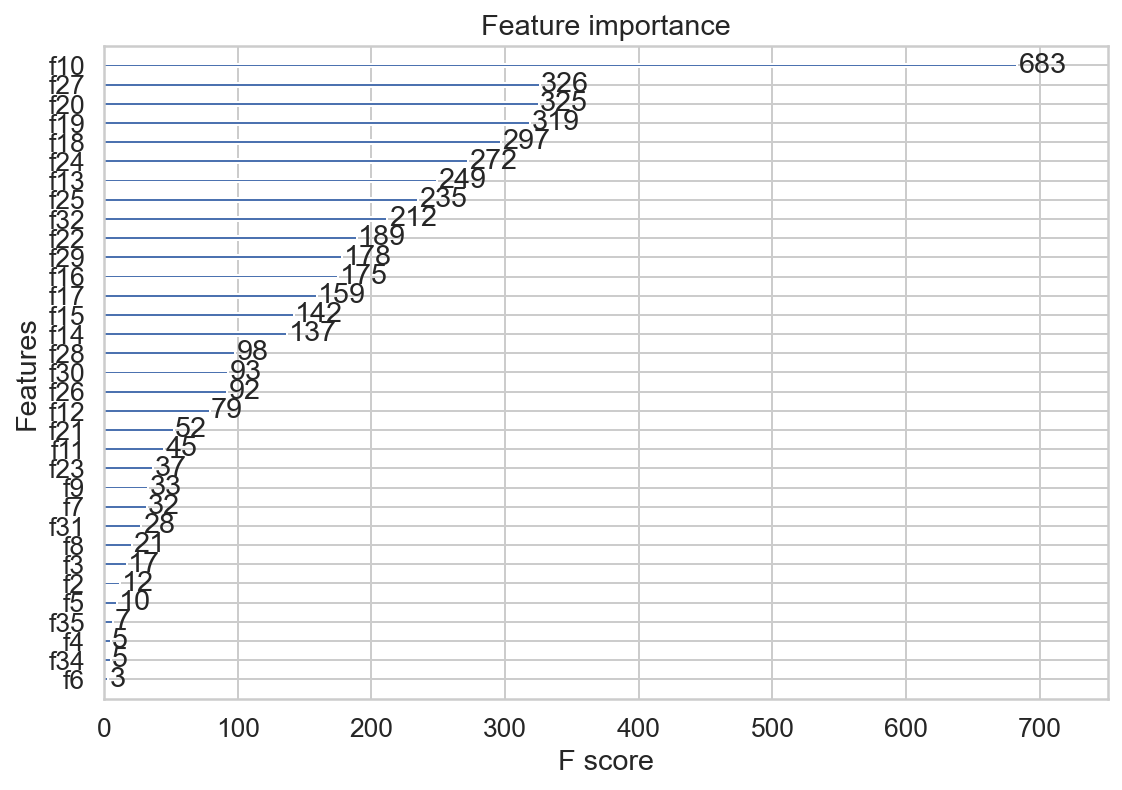

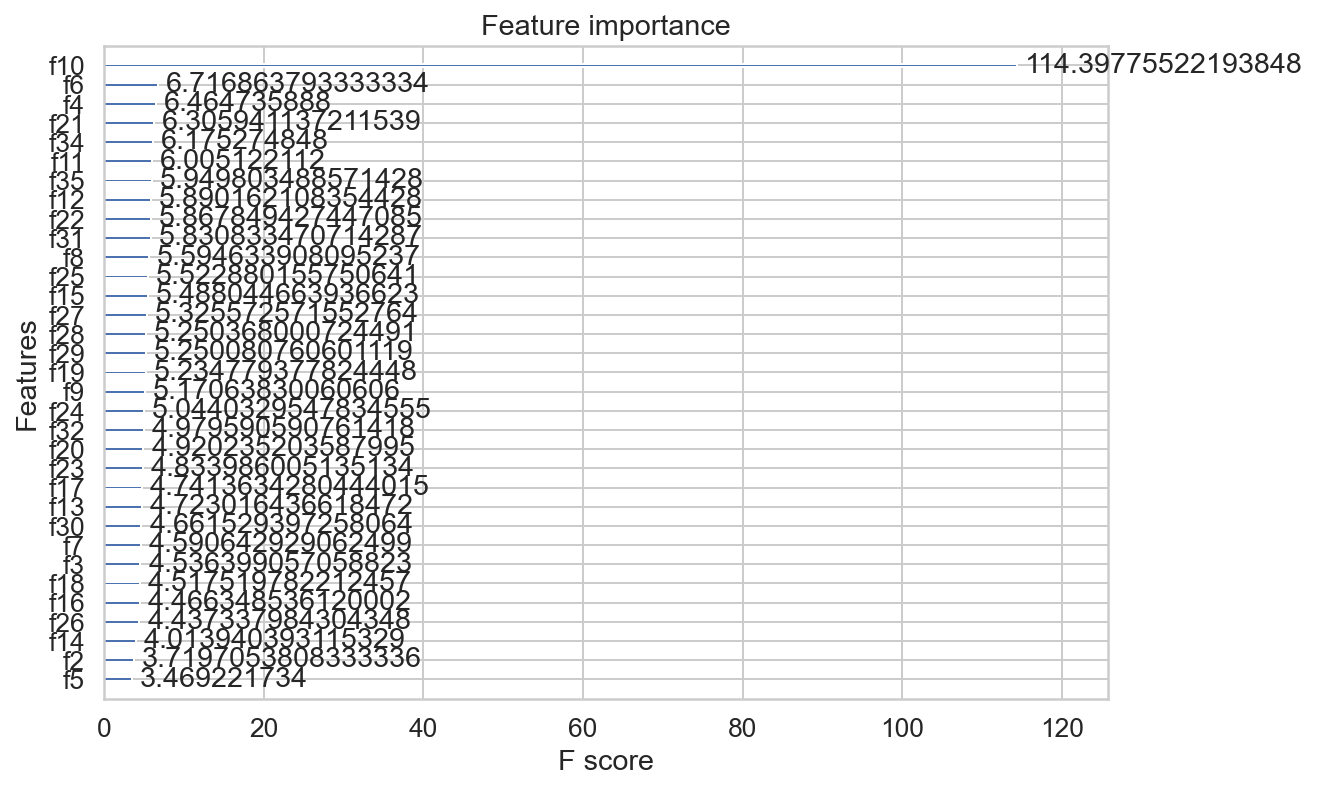

In [122]:
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb
xgb.plot_importance(xg_model)
xgb.plot_importance(xg_model, importance_type='gain');

### Re-running w/ only top features from XGBoost (cut off at 100 or higher feature importance)

In [152]:
xg_columns = ['place_odds', 'diff_from_field_handicap_wgt_avg', 'three_race_rolling_average_distance_per_time', 'three_race_rolling_average_time', 'three_race_rolling_average_lengths', 'diff_from_field_age_avg', 'declared_weight', 'diff_from_field_declared_wgt_avg', 'career_show_rate', 'diff_from_field_rating_avg', 'career_races', 'draw', 'three_race_rolling_avg_finish', 'horse_rating', 'actual_weight']

In [153]:
X = comb_training_horses_7_cleaned_po[xg_columns]
y = comb_training_horses_7_cleaned_po['show']

In [126]:
knn = KNN_accuracy_scorer_f_fold(X, y, n = 41, k=5)

KeyboardInterrupt: 

In [154]:
logreg = log_accuracy_scorer_k_fold(X, y, k=5, threshold=0.5, C=1)

Confusion Matrix for Fold 1
[[8513  126]
 [2523  256]]


Confusion Matrix for Fold 2
[[8506  147]
 [2517  247]]


Confusion Matrix for Fold 3
[[8471  179]
 [2499  268]]


Confusion Matrix for Fold 4
[[8497  132]
 [2547  241]]


Confusion Matrix for Fold 5
[[8407  157]
 [2576  277]]


Logistic Regression Classification w/ KFOLD CV Results (k=5):
Log. Reg Accuracy scores:  [0.7679978980557015, 0.766663747043882, 0.7654375054742927, 0.7653499167907506, 0.760620127879478] 

Simple mean cv accuracy: 0.765 + 0.002 

Log. Reg Precision scores:  [0.6701570680628273, 0.6269035532994924, 0.5995525727069351, 0.646112600536193, 0.6382488479262672] 

Simple mean cv precision: 0.636 +- 0.023 

Log. Reg Recall scores:  [0.09211946743432889, 0.08936324167872649, 0.09685580050596314, 0.08644189383070301, 0.09709078163336839] 

Simple mean cv recall: 0.092 +- 0.004 

Log. Reg Fbeta (beta=0.5) scores:  [0.29719061992105866, 0.2845622119815668, 0.29418221734357847, 0.28154205607476634, 0.30180867291348873

In [128]:
rf_model = random_forest_eval_kfold(X,y, k=5)

Confusion Matrix for Fold 1
[[8119  520]
 [2058  721]]


Confusion Matrix for Fold 2
[[8103  550]
 [2091  673]]


Confusion Matrix for Fold 3
[[8099  551]
 [2063  704]]


Confusion Matrix for Fold 4
[[8145  484]
 [2062  726]]


Confusion Matrix for Fold 5
[[8022  542]
 [2126  727]]


Random Forest Classification w/ KFOLD CV Results (k=5, threshold = 0.5):
Random Forest Accuracy scores:  [0.7750919600630584, 0.7699921170184812, 0.7730577209424543, 0.776824034334764, 0.7670141017780503] 

Simple mean cv accuracy: 0.772 + 0.004
Random Forest Precision scores:  [0.580983078162772, 0.5502861815208504, 0.5609561752988048, 0.6, 0.5728920409771474] 

Simple mean cv precision: 0.573 +- 0.017
Random Forest Recall scores:  [0.2594458438287154, 0.2434876989869754, 0.2544271774485002, 0.26040172166427544, 0.25481948825797407] 

Simple mean cv recall: 0.255 +- 0.006
Random Forest Fbeta (beta=0.5) scores:  [0.4655818158336562, 0.4395245559038663, 0.4520354436881983, 0.4758783429470372, 0.458443687728

In [129]:
xg_model = xgboost_eval_kfold(X,y, k=5, threshold = 0.5)

[10:07:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 1
[[8251  388]
 [2100  679]]


[10:07:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 2
[[8163  490]
 [2103  661]]


[10:07:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_met

To me, it's clear XGBoost and Log. Reg. are outperforming the others on precision.  Therefore, moving forward I'll only be evaluating those two model types.

## MOVE TO final_modeling_nb.ipynb